# Анализ фильмов IMDb

Датасет представляет собой набор данных о фильмах:

1. movie_title — название фильма.
2. title_year — год выпуска.
3. content_rating — возрастной рейтинг.
4. budget — бюджет в $.
5. imdb_score — оценка IMDb.
6. genres — жанры.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

plt.style.use('seaborn-whitegrid')

df = pd.read_csv('movie_metadata.csv')
df.dropna(inplace=True)

#### Наиболее частые жанры
Если хотя бы у 300 фильмов присутствует жанр, то добавляем его в список жанров для анализа.

In [2]:
number_of_movies = {}
for genres in df.genres:
    for genre in genres.split('|'):
        if genre in number_of_movies:
            number_of_movies[genre] += 1
        else:
            number_of_movies[genre] = 0

genres = []
for genre in number_of_movies:
    if number_of_movies[genre] > 300:
        genres.append(genre)

print(*genres, sep=', ')

Action, Adventure, Fantasy, Sci-Fi, Thriller, Romance, Comedy, Family, Mystery, Drama, Crime, Horror


#### Визуализируем данные рейтинга IMDb

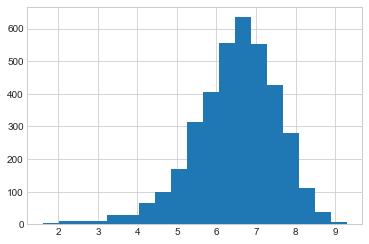

In [3]:
df['imdb_score'].hist(bins=19);

#### Проверка на нормальность

Проверим на нормальность распределения рейтинга IMDb по жанрам

In [4]:
alpha = 0.05

genres_df = pd.DataFrame(columns=['mean', 'std', 'D', 'p-value', 'H0'])

for genre in genres:
    data = df[df['genres'].str.contains(genre)]
    
    a = data['imdb_score'].mean()
    sigma = data['imdb_score'].std()
    
    cdf = stats.norm(loc=a, scale=sigma).cdf
    kstest = stats.kstest(rvs=data['imdb_score'], cdf=cdf, alternative='greater')
    genres_df.loc[genre] = [a, sigma, *kstest, kstest[1] > alpha]
    
    
def true_green_color(var):
    color = 'Green' if var else 'White'
    return 'background-color: ' + color    
    
    
genres_df.sort_values(by=['mean'], ascending=False).style.applymap(true_green_color, subset=['H0'])

,mean,std,D,p-value,H0
Drama,6.78917,0.896708,0.0363123,0.00662268,False
Crime,6.54513,0.983634,0.0367046,0.14445,True
Mystery,6.47396,1.01608,0.0334377,0.414494,True
Adventure,6.44981,1.114,0.0270065,0.314393,True
Romance,6.4383,0.954483,0.0384256,0.0771135,True
Thriller,6.37699,0.971815,0.0281895,0.166293,True
Sci-Fi,6.32702,1.16103,0.0310039,0.37757,True
Action,6.28978,1.03887,0.0326005,0.127431,True
Fantasy,6.27751,1.1339,0.0226245,0.586285,True
Family,6.21357,1.16192,0.0281521,0.487169,True


Для 10 из 12 наиболее частых жанров при критическом значении равном 5% можно принять гипотезу о том, что распределение рейтинга IMDb нормальное.

Также заметим, что среднее по выборке сильно отличаются по жанрам.

#### Посмотрим на зависимость средней оценки в выборках определнного жанра
С помощью критерия Стьюдента для двух независимых выборок проверим гипотезу о равенстве среднего рейтинга IMDb для фильмов разных жанров.
В выборке X1 будут фильмы содержащие жанр 1, но не содержащие жанр 2.
В выборке X2 наоборот. То есть фильмы в двух выборках не будут пересекаться.

In [5]:
alpha = 0.05
genres = ['Drama', 'Horror', 'Comedy', 'Romance', 'Mystery', 'Adventure', 'Crime', 'Thriller', 'Sci-Fi', 'Action', 'Family', 'Fantasy']

genres_df = pd.DataFrame(columns=genres)

for genre1 in genres:
    a = []
    for genre2 in genres:
        if genre1 == genre2:
            a.append(True)
            continue
        X1 = df[df['genres'].str.contains(genre1) & ~df['genres'].str.contains(genre2)]['imdb_score']
        X2 = df[~df['genres'].str.contains(genre1) & df['genres'].str.contains(genre2)]['imdb_score']
        n1, n2 = len(X1), len(X2)
        T = (X1.mean() - X2.mean()) / np.sqrt(np.var(X1) / n1 + np.var(X2) / n2)
        t = stats.t.ppf(1 - alpha / 2, n1 + n2 - 2)
        a.append(-t < T < t)
    genres_df.loc[genre1] = a
    
genres_df.style.applymap(true_green_color)

,Drama,Horror,Comedy,Romance,Mystery,Adventure,Crime,Thriller,Sci-Fi,Action,Family,Fantasy
Drama,True,False,False,False,False,False,False,False,False,False,False,False
Horror,False,True,False,False,False,False,False,False,False,False,False,False
Comedy,False,False,True,False,False,False,False,False,False,False,False,False
Romance,False,False,False,True,True,True,False,True,True,False,False,False
Mystery,False,False,False,True,True,True,True,True,True,False,False,False
Adventure,False,False,False,True,True,True,True,True,False,False,False,False
Crime,False,False,False,False,True,True,True,False,False,False,False,False
Thriller,False,False,False,True,True,True,False,True,True,False,False,True
Sci-Fi,False,False,False,True,True,False,False,True,True,True,True,True
Action,False,False,False,False,False,False,False,False,True,True,True,True


True в таблице означает, что мы принимаем гипотезу о том, что средняя оценка двух жанров равна.

Особняком стоят жанры `Drama, Horror, Comedy`

# Что ещё сделать

>С помощью многфакторного дисперсионного анализа сравним выборки и найдем признаки не зависящие от жанра

>С помощью лин регрессии предскажем рейтинг на основе важных признаков из первого пункта

>Оценка значимости уравнения линейной регрессии